# Step-by-Step ARIMA Forecasting with Comparison
This notebook uses an external module to forecast one or more stocks using ARIMA.

In [174]:
# Importing Libraries
%matplotlib inline

import importlib
import os
import sys
sys.path.append("../scripts")
import arima_forecasting_utils as afu

import warnings
warnings.filterwarnings("ignore")

## Step 1: Input stock and forecast duration

In [175]:
# Get Stock Input
tickers, years = afu.get_stock_input()

Enter stock ticker(s) or company name(s) (comma-separated):  lloyds, cocacola
Enter number of years to forecast:  10


Resolved stock codes: ['LLOY.L', 'COLA.WA']


## Step 2: Load Stock Data

In [176]:
# Display stock data
display_data, raw_data = afu.load_all_data(tickers)
for code, df in display_data.items():
    print(f"\nSample for {code}:")
    display(df.tail())



Sample for LLOY.L:


,date,open,high,low,close,volume,dividends,stock splits,ticker
2522,2025-03-25 00:00:00+00:00,72.580002,73.620003,72.500000,73.379997,154240079,0.0,0.0,LLOY.L
2523,2025-03-26 00:00:00+00:00,73.660004,74.059998,72.980003,73.360001,170809473,0.0,0.0,LLOY.L
2524,2025-03-27 00:00:00+00:00,72.660004,74.000000,72.199997,74.000000,145705643,0.0,0.0,LLOY.L
2525,2025-03-28 00:00:00+00:00,73.440002,74.279999,73.160004,73.400002,122117702,0.0,0.0,LLOY.L
2526,2025-03-31 00:00:00+01:00,72.739998,72.919998,71.279999,72.180000,32373499,0.0,0.0,LLOY.L



Sample for COLA.WA:


,date,open,high,low,close,volume,dividends,stock splits,ticker
50,2025-03-25 00:00:00+01:00,266.500000,268.549988,266.500000,268.549988,4,0.0,0.0,COLA.WA
51,2025-03-26 00:00:00+01:00,268.549988,268.549988,268.549988,268.549988,1,0.0,0.0,COLA.WA
52,2025-03-27 00:00:00+01:00,271.399994,271.399994,271.399994,271.399994,5,0.0,0.0,COLA.WA
53,2025-03-28 00:00:00+01:00,275.399994,275.399994,275.399994,275.399994,3,0.0,0.0,COLA.WA
54,2025-03-31 00:00:00+02:00,275.399994,275.399994,275.399994,272.549988,3,0.0,0.0,COLA.WA


## Step 3: Preprocess to Weekly Log Returns

In [177]:
#  computing the logarithmic weekly frequency (mean of 'close') to normalize the data. data to w

weekly_display, weekly_raw = afu.preprocess_all_data(raw_data)
for code, df in weekly_display.items():
    print(f"\nWeekly Returns for {code}:")
    display(df.tail())



Weekly Returns for LLOY.L:


,date,close,weekly_ret,ticker
517,2025-03-09 00:00:00+00:00,72.099998,0.022725,LLOY.L
518,2025-03-16 00:00:00+00:00,68.495999,-0.051279,LLOY.L
519,2025-03-23 00:00:00+00:00,70.536002,0.029348,LLOY.L
520,2025-03-30 00:00:00+00:00,73.300000,0.038437,LLOY.L
521,2025-04-06 00:00:00+01:00,72.180000,-0.015398,LLOY.L



Weekly Returns for COLA.WA:


,date,close,weekly_ret,ticker
12,2025-03-09 00:00:00+01:00,274.465698,-0.010882,COLA.WA
13,2025-03-16 00:00:00+01:00,269.266495,-0.019125,COLA.WA
14,2025-03-23 00:00:00+01:00,269.619995,0.001312,COLA.WA
15,2025-03-30 00:00:00+01:00,270.489990,0.003222,COLA.WA
16,2025-04-06 00:00:00+02:00,272.549988,0.007587,COLA.WA


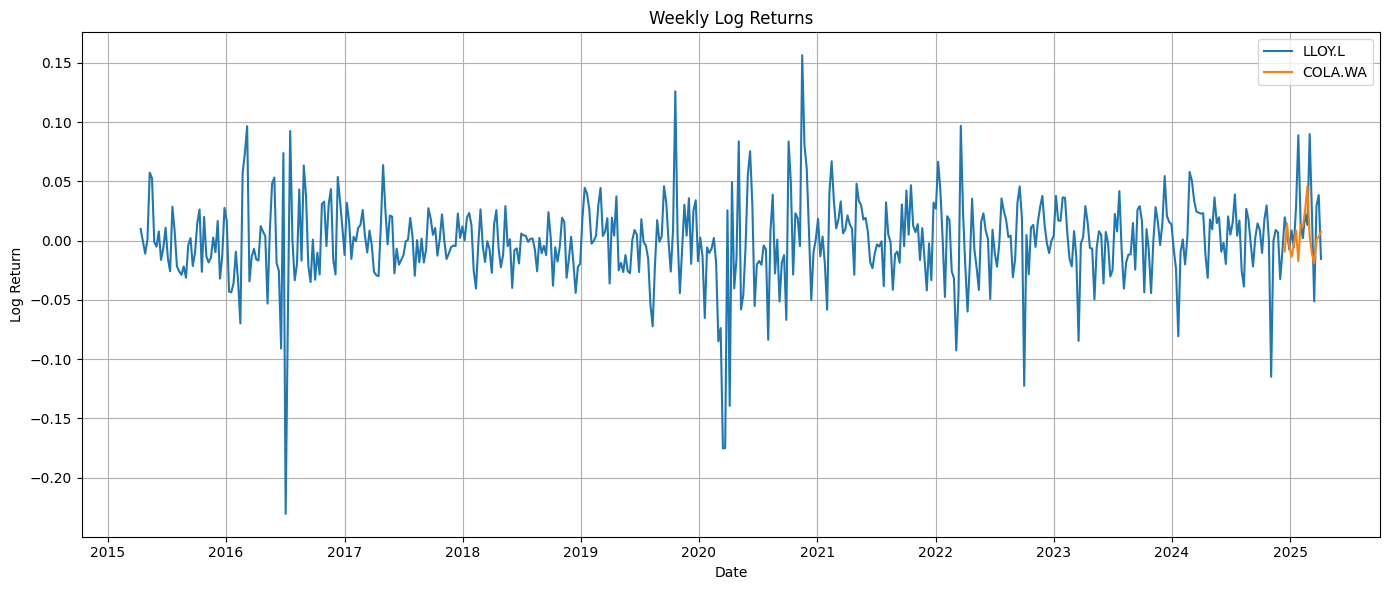

In [178]:
# visualizing the weekly returns.
afu.plot_weekly_returns(weekly_raw)

## Step 4: Stationarity Check and Differencing
> stationary time series has a constant mean and variance over time, which is a prerequisite for ARIMA modelling.
> I'll be using rolling mean/std + ADF test. Optional plots for diagnosis for each ticker

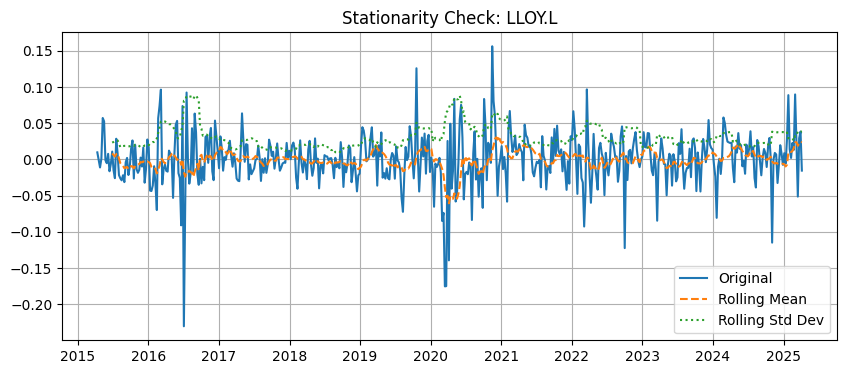

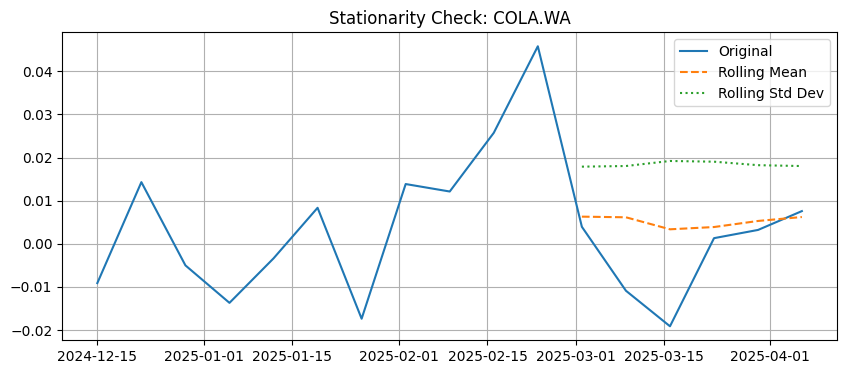

,Ticker,ADF Statistic,p-value,Conclusion
0,LLOY.L,-18.5856,2.075854e-30,Stationary
1,COLA.WA,-2.2811,1.781314e-01,Not Stationary


In [179]:
# Rolling mean/std + Augmented Dickey-Fuller test to statistically check stationarity.
returns = {k: v["weekly_ret"] for k, v in weekly_raw.items()}
summary_df = afu.summarize_adf_tests(returns, plot=True)
display(summary_df)

**Stationarity Test Results (ADF)**

The Augmented Dickey-Fuller (ADF) test checks whether a time series is stationary.:
Hypotheses:
- **H₀ (Null Hypothesis):** The series is *not* stationary
- **H₁ (Alternative Hypothesis):** The series *is* stationary

* Decision Rule:* If **p-value < 0.05**, reject H₀ ⇒ The series is **stationary**

**Conclusion:**  
Ticker(s) weekly return series are stationary — no differencing required (d=0). **Hence we can proceed with finding the best ARIMA model for forecasting**

In [180]:
# if not stationary make stationary
stationary_series, diff_orders = afu.make_all_stationary_auto(
    {k: v["weekly_ret"] for k, v in weekly_raw.items()}
)

LLOY.L - ADF Statistic: -18.59, p-value: 2.0758544782794618e-30
LLOY.L: Final differencing applied d = 0
COLA.WA - ADF Statistic: -2.28, p-value: 0.17813137962001813
COLA.WA (d=1) - ADF Statistic: -4.80, p-value: 5.503186006569675e-05
COLA.WA: Final differencing applied d = 1


## Step 5: Find Best ARIMA Parameters (AIC)

In [170]:
#importlib.reload(afu)

<module 'arima_forecasting_utils' from 'D:\\portfolio\\my_projects\\DataAnalysis\\scripts\\arima_forecasting_utils.py'>

### ACF PACF Checks for p, q

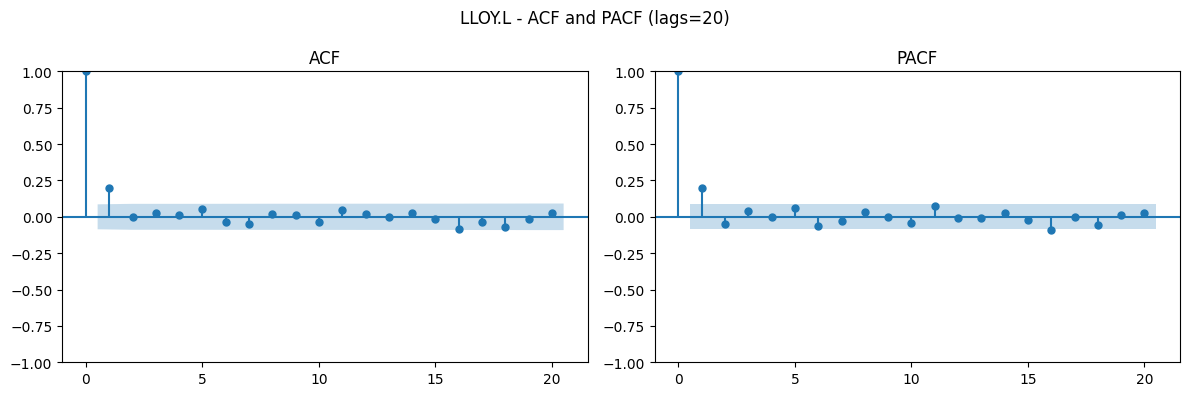

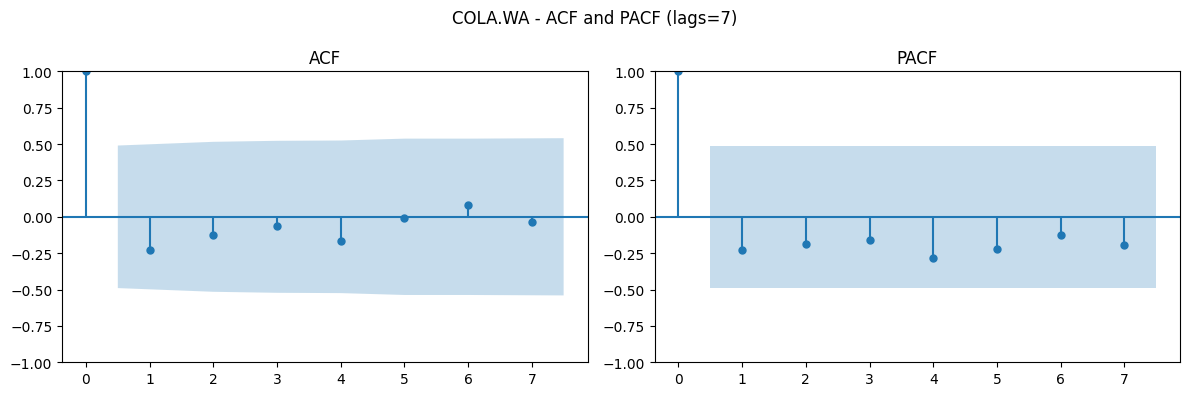

⚠️ No significant spikes for LLOY.L. Using fallback ARIMA(1, 0, 1)
LLOY.L → Suggested ARIMA(p,d,q): (1, 0, 1)
⚠️ No significant spikes for COLA.WA. Using fallback ARIMA(1, 1, 1)
COLA.WA → Suggested ARIMA(p,d,q): (1, 1, 1)


In [181]:
# Plot ACF to help visually inspect ideal p and q values.
afu.plot_all_acf_pacf(stationary_series)

# Suggest ARIMA params
suggestions = afu.suggest_arima_params(stationary_series, diff_orders)


ARIMA Parameter Inference from ACF and PACF

To identify the optimal ARIMA `(p, d, q)` parameters:

| Plot  | Cutoff Interpretation         | Suggests |
|-------|-------------------------------|----------|
| **PACF** | Cutoff after lag `p`          | AR(`p`)  |
| **ACF**  | Cutoff after lag `q`          | MA(`q`)  |

Since the series are **already stationary**, we set `d = 0`.

**Inferred Parameters from Plots:**
 **GOOG**
> - **PACF**: Significant spike at lag **1**, then drops  ⇒ AR(`p`) = **1**
> - **ACF**: Significant spike at lag **1**, then flat    ⇒ MA(`q`) = **1**
> - *Suggested ARIMA for GOOG:* `(1, 0, 1)`

**AAPL**
> - **PACF**: Spike at lag **1**, then decays    ⇒ AR(`p`) = **1**
> - **ACF**: Spike at lag **1**, then flat    ⇒ MA(`q`) = **1**
> - > *Suggested ARIMA for AAPL:* `(1, 0, 1)`

### ARIMA AIC optimization

- to automate finding the best (p, d, q), we can run a grid search over a range of values and select the parameters with the lowest AIC (Akaike Information Criterion) and MSE (Mean Squared Error).
- To enhance ARIMA model selection process by incorporating Mean Squared Error (MSE) along with Akaike Information Criterion (AIC).
- This approach ensures that I select the best ARIMA model based on both AIC (which indicates model fit) and MSE (which measures forecasting accuracy).
- divide the dataset into a training set (60%) and a testing set (40%).
- fit model on the training set and forecast values for the testing set.bMSE is calculated between the actual test values and the predicted values.
- model with the lowest AIC is retained. In case of ties in AIC, it favours the one with the lowest MSE.

In [182]:
# Using suggested params to optimize ARIMA per series (AIC)
best_orders = {
    ticker: afu.find_best_arima(series, ticker=ticker, **suggestions[ticker])
    for ticker, series in returns.items()
}

LLOY.L → Best ARIMA near (1, 0, 1): (0, 0, 1) | AIC: -2026.26 | MSE: 0.001193
COLA.WA → Best ARIMA near (1, 1, 1): (1, 1, 1) | AIC: -79.29 | MSE: 0.000284


## Step 6: Fit and Evaluate Best Model

LLOY.L | ARIMA(0, 0, 1) | Residual Mean: -0.0000, Std: 0.0346, Kurtosis: 8.11, Ljung-Box p-value: 0.7256 → Good fit


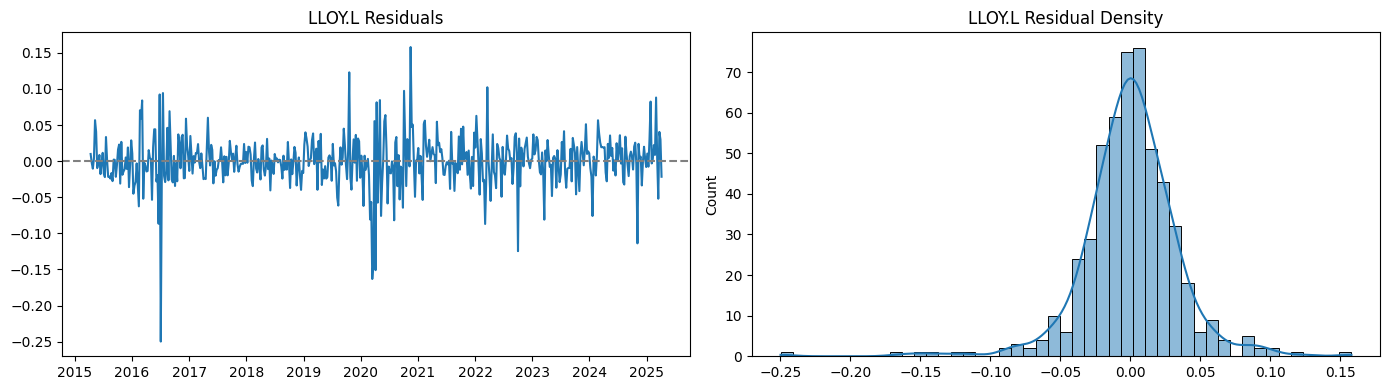

COLA.WA | ARIMA(1, 1, 1) | Residual Mean: 0.0022, Std: 0.0168, Kurtosis: -1.08, Ljung-Box p-value: 0.8760 → Good fit


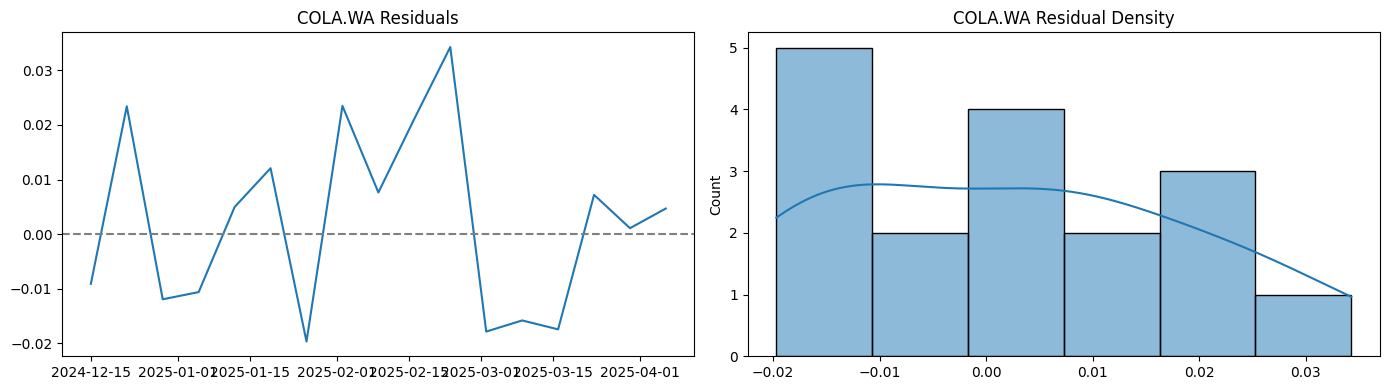

,Ticker,ARIMA Order,Residual Mean,Residual Std,Kurtosis,Ljung-Box p-value,Good Fit
0,LLOY.L,"(0, 0, 1)",-0.000004,0.034575,8.111627,0.725582,True
1,COLA.WA,"(1, 1, 1)",0.002205,0.016846,-1.076012,0.875958,True


In [183]:
# Residual Analysis: to ensure they are randomly distributed (white noise).
results_df = afu.evaluate_arima_residuals(returns, best_orders, plot=True)
display(results_df)


**Residual Diagnostics for ARIMA Model Fit**

I examined the **residuals** (errors between predicted and actual values) to validate that a fitted Best ARIMA model is appropriate. What was Checked:

| Metric                | What it Tells Us                                      | Desired Outcome                     |
|-----------------------|-------------------------------------------------------|-------------------------------------|
| **Mean of residuals** | If the errors are centered around 0                  | Close to 0                          |
| **Std of residuals**  | Spread of the errors (no strict threshold)           | Moderate / consistent               |
| **Kurtosis**          | Shape of residual distribution (tail heaviness)      | Close to 3 (normal distribution)    |
| **Ljung-Box p-value** | Are residuals autocorrelated?                        | **p > 0.05** (no autocorrelation)   |

- If all criteria are met, we consider the model a **Good Fit**
- If the Ljung-Box p-value is **< 0.05**, residuals are autocorrelated → **Poor Fit**

Included is the **Residual time series** to visually spot patterns or drifts and **Density plots** to assess normality and distribution shape

**Both ARIMA models (GOOG and AAPL) exhibit:**
- Unbiased and stable forecast errors ( the model is not consistently over- or under-predicting, and forecast error variability is stable across tickers.
- No autocorrelation in the residuals (p > 0.0)
- Reasonably shaped error distributions (values indicate flatter-than-normal (platykurtic) distributions. There are fewer outliers, meaning errors are generally moderate and not extreme — which is good.)

 ***These are well-fitting models suitable for forecasting.***

## Step 7: Forecast and Visualize

Do you want to save the forecast to CSV file? (y/n):  n


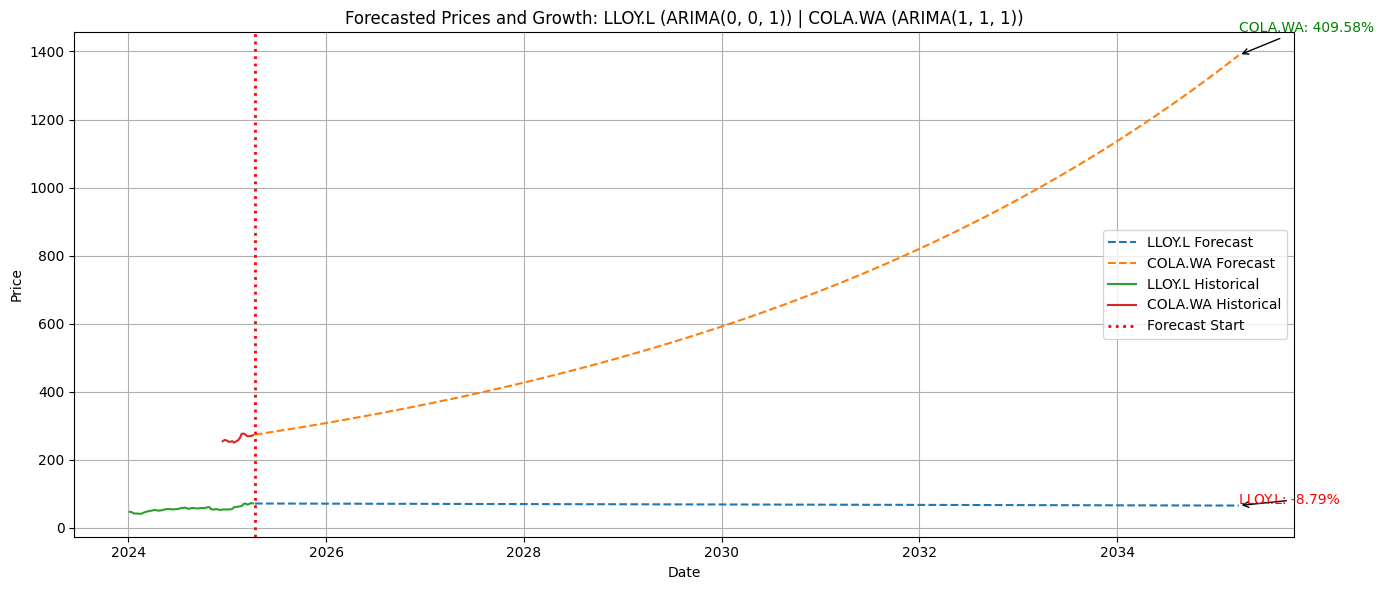

,LLOY.L_price,LLOY.L_pct_growth,LLOY.L_rolling_avg,COLA.WA_price,COLA.WA_pct_growth,COLA.WA_rolling_avg
2025-04-12 22:00:00+00:00,$0.00,0.00%,$0.00,$273.86,0.48%,$0.00
2025-04-12 23:00:00+00:00,$71.84,-0.47%,$0.00,$0.00,0.00%,$0.00
2025-04-19 22:00:00+00:00,$0.00,0.00%,$0.00,$274.88,0.86%,$0.00
2025-04-19 23:00:00+00:00,$71.83,-0.49%,$0.00,$0.00,0.00%,$0.00
2025-04-26 22:00:00+00:00,$0.00,0.00%,$0.00,$275.80,1.19%,$0.00


In [184]:
# Inverse Transform to Price: To make the forecast interpretable, we convert the returns back to price levels.
forecast_table = afu.forecast_prices(
    series_dict=returns,
    close_dict=weekly_raw,
    best_orders_dict=best_orders,
    years=years
)

forecast_table.head()

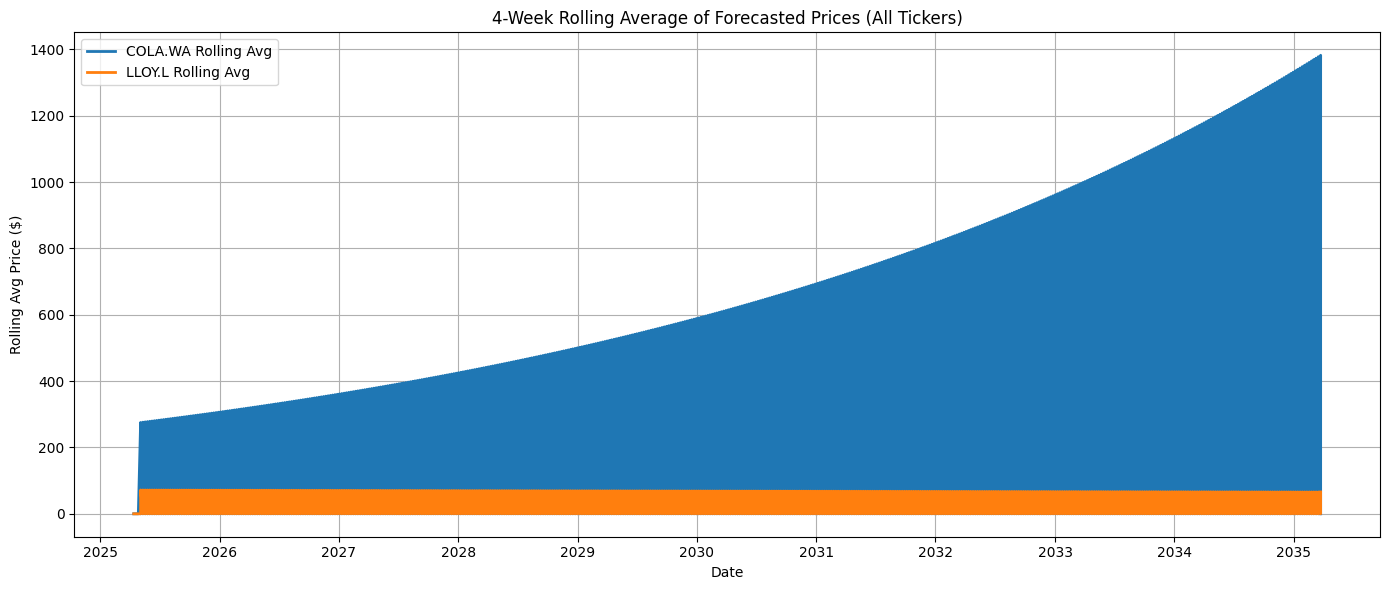

In [185]:
# Plot rolling averages
afu.plot_combined_rolling_average(forecast_table)

## ARIMA Forecast Summary

**Forecast Overview**

| Ticker | ARIMA Order | Projected Growth | Forecast Horizon |
|--------|-------------|------------------|------------------|
| `GOOG`   | (1, 0, 2)   | 590.59%      | ~10 years        |
| `AAPL`   | (0, 0, 1)   | 702.59%      | ~10 years        |

Both stocks demonstrate **strong upward trends** over the forecast horizon with **weekly prices rising steadily**. The ARIMA models predict a **compound effect of returns**, indicating sustained momentum over time.

*Trend Observations*
> - `GOOG`: Consistent exponential growth pattern with compounding returns.
> - `AAPL`: Even stronger acceleration over time, possibly indicating higher return expectations or volatility.
> - Rolling averages (4-week) provide a smoothed view and confirm the upward direction without significant short-term dips.

## Real-Life Implication & Caution

Real-Life Implications
> - **For Investors**: This suggests that both `GOOG` and `AAPL` may represent `solid long-term investments` under current trends. The projected price growth shows the power of `compounding in stable equities`.
> - **For Portfolio Managers**: Such forecasts can inform `allocation strategies`, particularly when balancing growth vs. value assets.
> - **For Business Planners**: If you're operating in sectors tied to these companies, the bullish trend may influence strategic decisions (e.g., product partnerships, tech integrations).

Caution
> - These projections are `model-based` and assume historical trends persist. Real-world factors like economic shifts, policy changes, or company events can alter outcomes.
> - Always `complement model outputs with fundamental and technical analysis` before investment decisions.